In [1]:
import os,csv,re,sys
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
import random, torch
from sklearn import metrics
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
data_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb/'
save_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/Mouse_Olfactory_Bulb/SpaGCN/'
os.makedirs(save_path, exist_ok=True)

n_clusters = 7

In [3]:
counts_file = os.path.join(data_path, 'RNA_counts.tsv.gz')
coor_file = os.path.join(data_path, 'position.tsv')

counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [4]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

adata = sc.read_h5ad(os.path.join(data_path, 'raw.h5ad'))
adata.var_names_make_unique()

coords = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

used_barcode = pd.read_csv(os.path.join(data_path, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
adata

/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

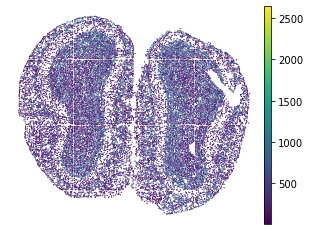

In [18]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [21]:
spatial = pd.read_csv(os.path.join(data_path, 'position.tsv'), sep='\t',na_filter=False)
spatial[1]

,x,y,label
0,12555.007833,6307.537859,1
1,12623.666667,6297.166667,2
2,12589.567164,6302.552239,3
3,12642.495050,6307.386139,4
4,13003.333333,6307.990991,5
...,...,...,...
19522,14656.130435,12156.869565,19888
19523,10717.785714,12189.571429,19889
19524,10872.913580,12190.123457,19890
19525,11628.769231,12191.846154,19891


In [23]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

In [22]:
adata.obs

,x,y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
Spot_1,12555.007833,6307.537859,428,6.061457,490.842621,6.198159,21.799251,33.176138,53.549266,100.000006
Spot_10,12806.715054,6311.983871,209,5.347108,240.722229,5.487789,33.948764,54.719595,96.261251,100.000000
Spot_100,12752.469565,6425.617391,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.000000
Spot_1000,12545.601942,6856.786408,177,5.181784,212.833328,5.365197,40.328892,63.821451,99.999993,99.999993
Spot_10000,12993.429134,9153.204724,332,5.808142,386.515137,5.959755,27.040377,39.976481,65.848689,100.000000
...,...,...,...,...,...,...,...,...,...,...
Spot_9994,14127.819588,9148.005155,275,5.620401,325.076904,5.787133,30.785614,46.166589,76.928541,100.000000
Spot_9995,12933.872611,9147.484076,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.000000
Spot_9996,13328.963303,9155.389908,334,5.814131,388.083313,5.963793,26.733950,39.703677,65.471340,100.000008
Spot_9998,12637.854167,9150.281250,122,4.812184,136.833344,4.926045,47.381240,83.922046,100.000000,100.000000


In [26]:
adata.obsm['spatial']

array([[ 6307.53785901, 12555.0078329 ],
       [ 6311.98387097, 12806.71505376],
       [ 6425.6173913 , 12752.46956522],
       ...,
       [ 9155.38990826, 13328.96330275],
       [ 9150.28125   , 12637.85416667],
       [ 9155.12612613, 12959.04954955]])

In [28]:
x_pixel = adata.obs['x'].tolist()
y_pixel = adata.obs['y'].tolist()
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)

##### Spatial domain detection using SpaGCN
spg.prefilter_genes(adata, min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

### 4.2 Set hyper-parameters
p=0.5 
spg.test_l(adj,[1, 10, 100, 500, 1000])
l=spg.search_l(p=p,adj=adj,start=0.01, end=1000, tol=0.01, max_run=100)
n_clusters=n_clusters
r_seed=t_seed=n_seed=100
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, 
                    t_seed=t_seed, n_seed=n_seed)

### 4.3 Run SpaGCN
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')



Calculateing adj matrix using xy only...
l is  1 Percentage of total expression contributed by neighborhoods: 0.0
l is  10 Percentage of total expression contributed by neighborhoods: 0.19605684280395508
l is  100 Percentage of total expression contributed by neighborhoods: 61.295921325683594
l is  500 Percentage of total expression contributed by neighborhoods: 1297.826847660292
l is  1000 Percentage of total expression contributed by neighborhoods: 4133.363943343861
Run 1: l [0.01, 1000], p [0.0, 4133.363943343861]
Run 2: l [0.01, 500.005], p [0.0, 1297.85009765625]
Run 3: l [0.01, 250.0075], p [0.0, 358.6799621582031]
Run 4: l [0.01, 125.00874999999999], p [0.0, 94.66525268554688]
Run 5: l [0.01, 62.509375], p [0.0, 24.212900161743164]
Run 6: l [0.01, 31.2596875], p [0.0, 5.740363597869873]
Run 7: l [0.01, 15.63484375], p [0.0, 1.0215144157409668]
Run 8: l [7.822421875, 15.63484375], p [0.05272257328033447, 1.0215144157409668]
Run 9: l [11.728632812499999, 15.63484375], p [0.3848789

/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch  0
delta_label  0.0 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 1
Res =  0.01 Num of clusters =  1
Initializing cluster centers with louvain, resolution =  0.11
Epoch  0
Epoch  10
Res =  0.11 Num of clusters =  2
Res changed to 0.11
Initializing cluster centers with louvain, resolution =  0.21000000000000002
Epoch  0
Epoch  10
Res =  0.21000000000000002 Num of clusters =  2
Res changed to 0.21000000000000002
Initializing cluster centers with louvain, resolution =  0.31000000000000005
Epoch  0
Epoch  10
Res =  0.31000000000000005 Num of clusters =  3
Res changed to 0.31000000000000005
Initializing cluster centers with louvain, resolution =  0.41000000000000003
Epoch  0
Epoch  10
Res =  0.41000000000000003 Num of clusters =  3
Res changed to 0.41000000000000003
Initializing cluster centers with louvain, resolution =  0.51
Epoch  0
Epoch  10
Res =  0.51 Num of clusters =  3
Res changed to 0.51
Initializing cluster centers with louvain, resolution =  0.61


In [30]:
adata

AnnData object with n_obs × n_vars = 19109 × 24293
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'pred'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'spatial'

In [ ]:

sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

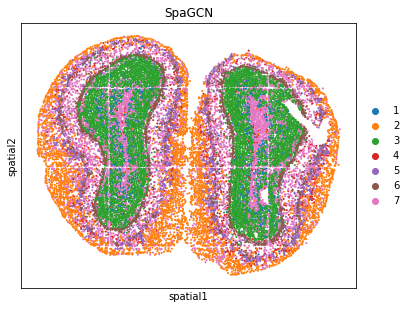

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='pred', ax=ax, show=False, title='SpaGCN', spot_size=40)
ax.invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
ax.legend(handles, new_labels, loc='center left',
          bbox_to_anchor=(1.0, 0.5), frameon=False) 
plt.savefig(os.path.join(save_path, 'clustering.pdf'), bbox_inches='tight', dpi=300)

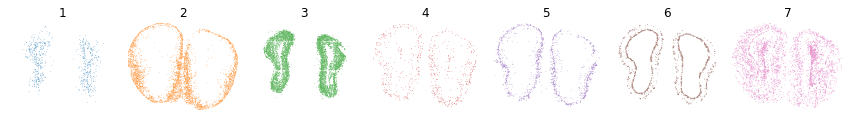

In [35]:
fig, axes = plt.subplots(1,n_clusters,figsize=(1.7*n_clusters, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata[adata.obs['pred'] == i]
    sc.pl.spatial(sub, spot_size=30, color='pred', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)
    
xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'each_cluster.pdf'), bbox_inches='tight', dpi=300)

In [36]:
cell_metadata = adata.obs
cell_metadata

,x,y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts,pred
Spot_1,12555.007833,6307.537859,428,6.061457,490.842621,6.198159,21.799251,33.176138,53.549266,100.000006,188.841522,1
Spot_10,12806.715054,6311.983871,209,5.347108,240.722229,5.487789,33.948764,54.719595,96.261251,100.000000,158.430405,1
Spot_100,12752.469565,6425.617391,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.000000,142.683624,1
Spot_1000,12545.601942,6856.786408,177,5.181784,212.833328,5.365197,40.328892,63.821451,99.999993,99.999993,150.283096,6
Spot_10000,12993.429134,9153.204724,332,5.808142,386.515137,5.959755,27.040377,39.976481,65.848689,100.000000,178.905426,1
...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_9994,14127.819588,9148.005155,275,5.620401,325.076904,5.787133,30.785614,46.166589,76.928541,100.000000,170.754288,1
Spot_9995,12933.872611,9147.484076,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.000000,157.902710,1
Spot_9996,13328.963303,9155.389908,334,5.814131,388.083313,5.963793,26.733950,39.703677,65.471340,100.000008,179.219040,1
Spot_9998,12637.854167,9150.281250,122,4.812184,136.833344,4.926045,47.381240,83.922046,100.000000,100.000000,131.985535,1


In [37]:
cell_metadata.to_csv(os.path.join(save_path, 'cell_metadata.csv'))